# Kernel-based Time-varying Regression - Part IV

We will continue to cover advance inputs for KTR. For other details you can also refer to the original paper Ng, Wang and Dai (2021).

In **Part IV**, we will cover advance inputs for regression including

- regressors signs
- adjusting knot sensitivity with respect to volume of response
- time-point coefficients priors 

In [4]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.plot import get_orbit_style

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)
orbit_style = get_orbit_style()
plt.style.context(orbit_style);

In [83]:
def sim_stepwise_coef_data(n, RS, p=3, n_jump=2):
    np.random.seed(RS)
    
    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    
    jump_tp = np.round(np.random.uniform(0, n, (p, n_jump)), 0).astype(np.int32)
    jump_amp = np.random.normal(0, 0.1, (p, n_jump))
    
    beta = np.zeros((n, p))
    beta[0, :] = -1.5
    for idx in range(p):
        beta[jump_tp[idx], idx] = jump_amp[idx]
    beta = np.cumsum(beta, 0)
    beta += np.random.normal(0, 1e-2, (n, p))
    # strictly positive coefficients
    beta = np.exp(beta)

    # simulate regressors
    covariates = np.random.normal(0, 1, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))
    
    # hack for p = 3 
    data['beta1'] = beta[:,0]
    data['beta2'] = beta[:,1]
    data['beta3'] = beta[:,2]    
    
    return data

In [84]:
data = sim_stepwise_coef_data(n=300, RS=2021, p=3, n_jump=2)
data.tail(10)

,x1,x2,x3,y,date,beta1,beta2,beta3
290,0.03155,-0.57452,0.06659,5.10411,2018-10-18,0.17162,0.25337,0.22347
291,-1.00310,0.47901,-0.53047,5.23974,2018-10-19,0.17194,0.25216,0.22092
292,0.28695,0.61022,0.66294,5.48032,2018-10-20,0.17073,0.25061,0.22510
293,-0.52936,1.48160,1.17136,5.67231,2018-10-21,0.17207,0.25340,0.22509
294,-0.58430,0.77060,-0.11744,5.51009,2018-10-22,0.17610,0.25398,0.22252
295,0.91221,-0.64489,-0.76538,4.79089,2018-10-23,0.17331,0.25274,0.21892
296,-1.03230,-0.61765,0.46613,4.87878,2018-10-24,0.17273,0.24676,0.22153
297,0.59207,-0.05361,0.95064,5.53987,2018-10-25,0.17823,0.25257,0.22188
298,-0.10021,0.04903,-0.89586,4.92437,2018-10-26,0.17223,0.25744,0.22285
299,1.72214,0.07972,-0.49909,5.38139,2018-10-27,0.17381,0.25428,0.22034


<AxesSubplot:>

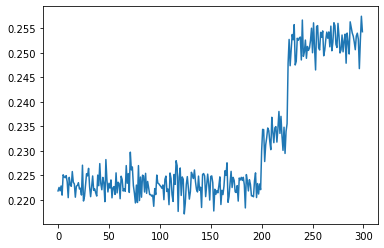

In [85]:
data['beta2'].plot()

In [86]:
# num of predictors
p = 3
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]
response_col = 'y'
date_col='date'

Here, we need to supply additional args to describe the regressors.

In [95]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    regressor_init_knot_scale=[1.0] * 3,
    regressor_knot_scale=[0.1] * 3,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)

After the initialization, the fit-and-predict would be similar to the previous models. And now you should expect a regression component reported in prediction if you specify `decompose=True`.

In [96]:
ktr.fit(df=data)
ktr.predict(df=data)

INFO:root:Guessed max_plate_nesting = 1


,date,prediction_2.5,prediction,prediction_97.5
0,2018-01-01,4.09773,4.76812,5.42231
1,2018-01-02,4.46397,5.04856,5.61600
2,2018-01-03,4.68061,5.27377,6.02504
3,2018-01-04,4.12033,4.71642,5.41158
4,2018-01-05,4.45857,5.02531,5.57943
...,...,...,...,...
295,2018-10-23,4.49002,5.07090,5.75010
296,2018-10-24,4.37430,5.00449,5.70300
297,2018-10-25,4.86800,5.46943,6.00925
298,2018-10-26,4.48838,5.07411,5.83473


## Visualization of Regression Coefficient Curves

First, we can leverage `get_regression_coefs` to extract coefficients with intervals by supplying argument `include_ci=True`.

In [97]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

In [98]:
coef_mid.head(5)

,date,x1,x2,x3
0,2018-01-01,0.15528,0.25345,0.17111
1,2018-01-02,0.15587,0.25328,0.17114
2,2018-01-03,0.15648,0.25312,0.17117
3,2018-01-04,0.15709,0.25295,0.17121
4,2018-01-05,0.15771,0.25279,0.17125


Let's overlay the estimate with the true coefficients.

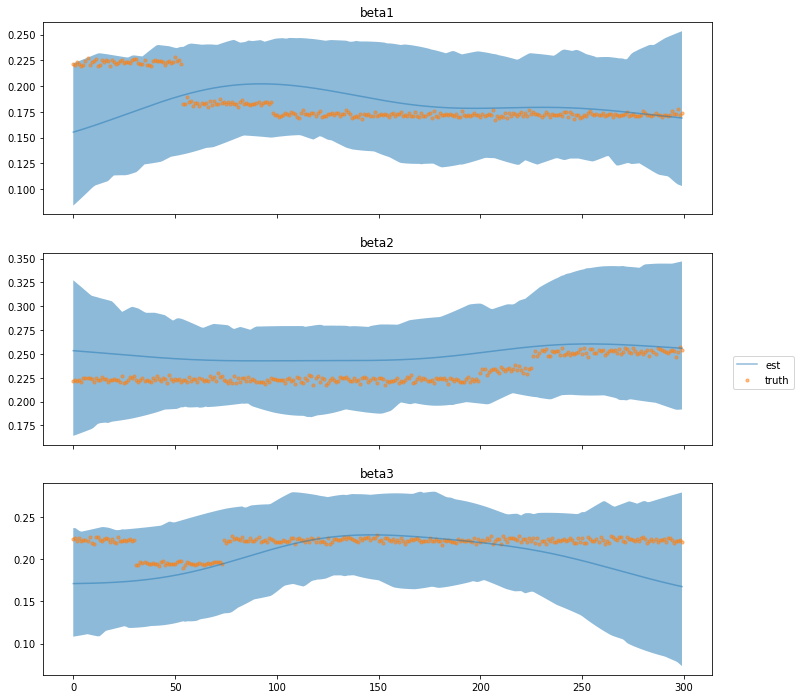

In [99]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.5)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.5)
    axes[idx].scatter(x, data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", s=10, alpha=0.5)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));